Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing atp - 10 files


  0%|          | 0/10 [00:00<?, ?it/s]

Processing nad - 10 files


  0%|          | 0/10 [00:00<?, ?it/s]

Processing heme - 10 files


  0%|          | 0/10 [00:00<?, ?it/s]

Processing palmitate - 10 files


  0%|          | 0/10 [00:00<?, ?it/s]

Processing citrate - 10 files


  0%|          | 0/10 [00:00<?, ?it/s]

Processed 50 protein-ligand pairs


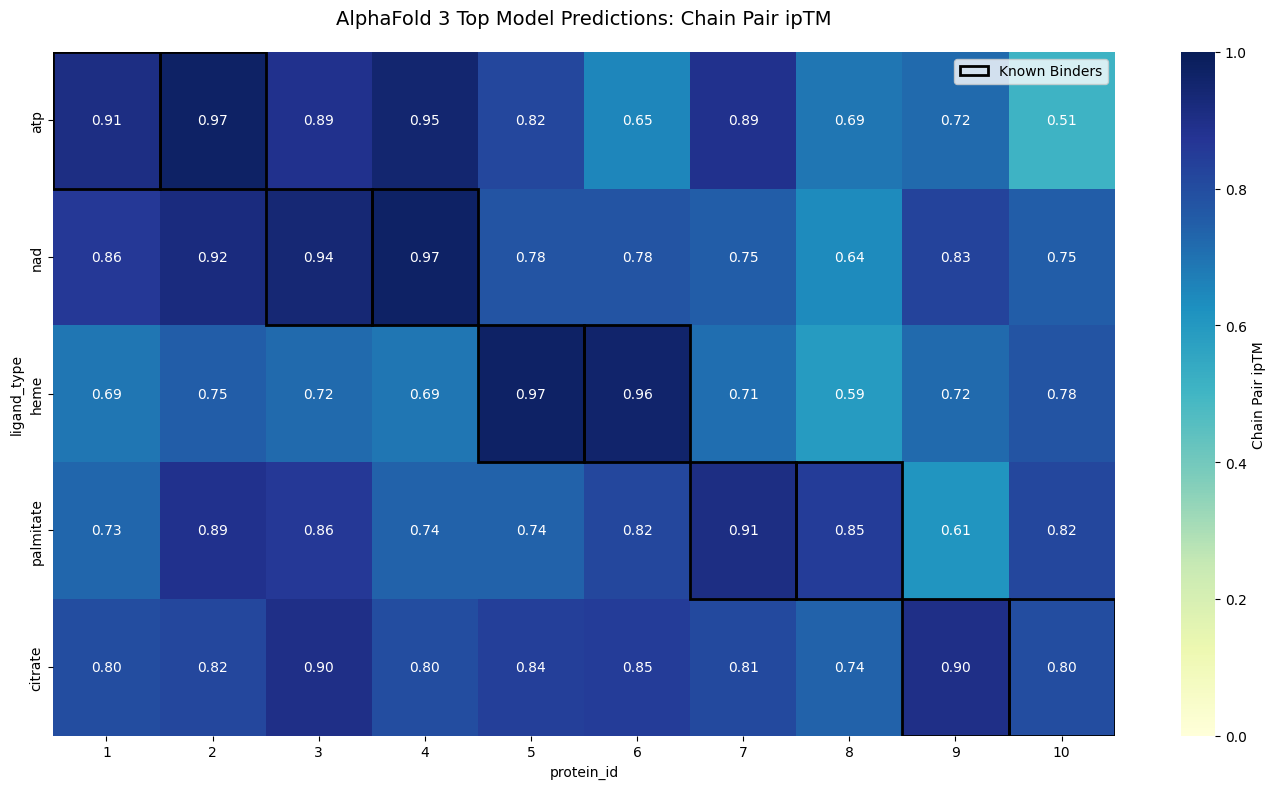

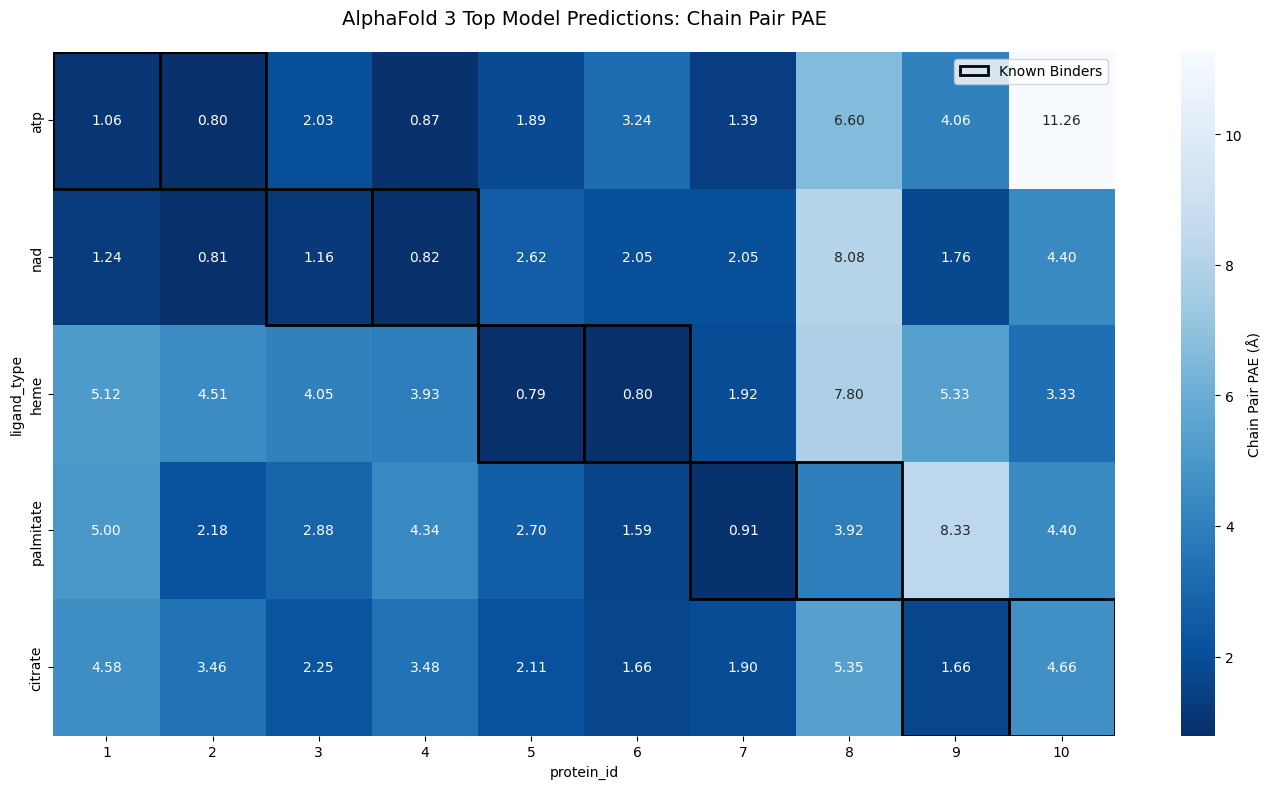

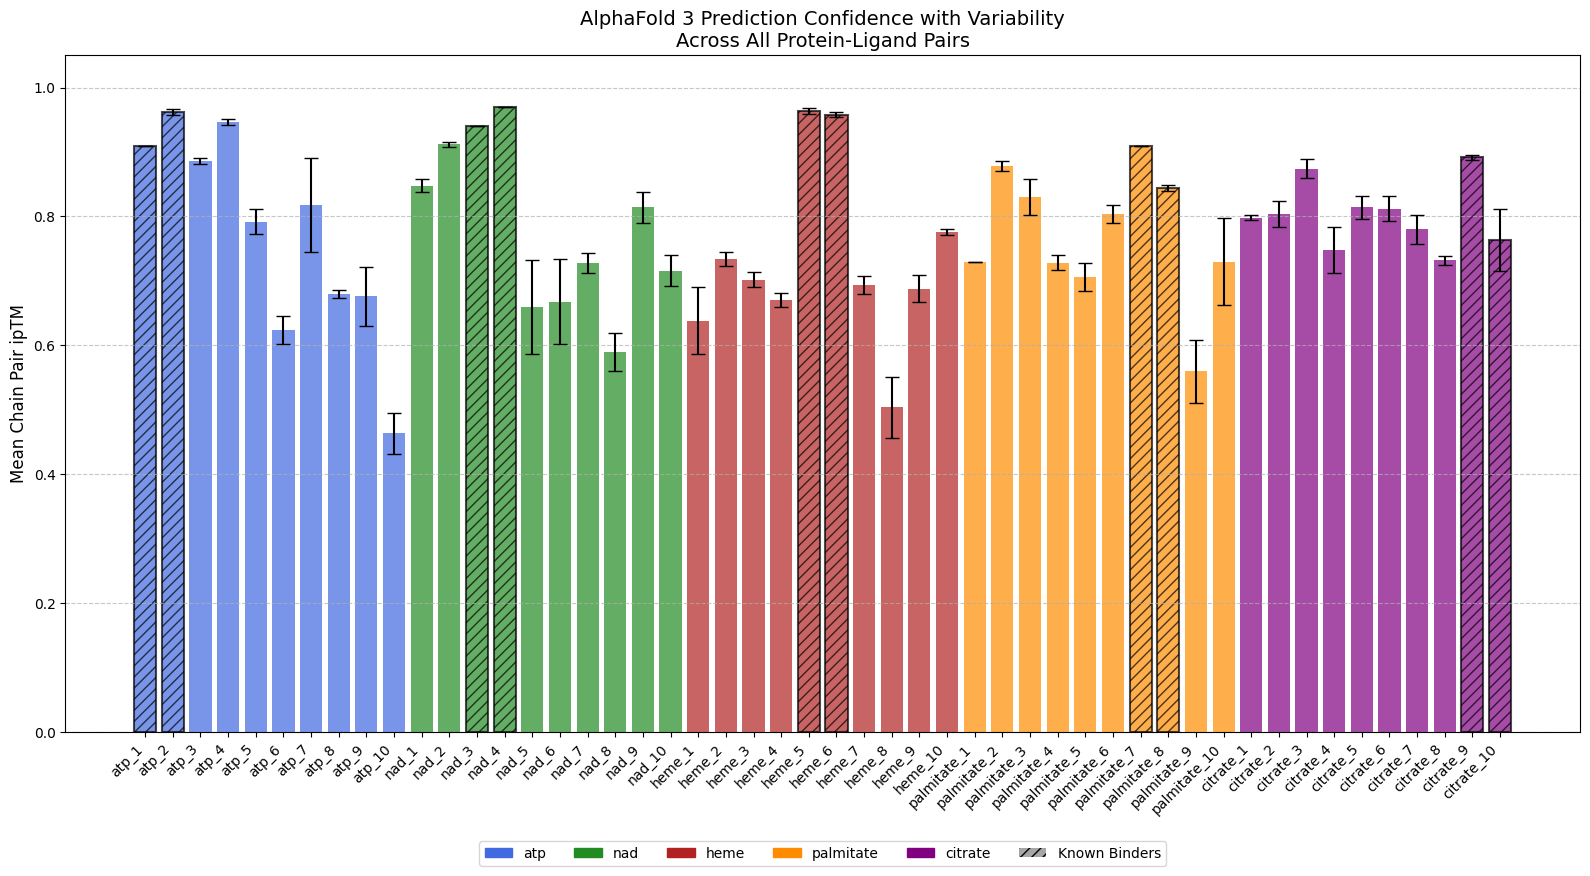

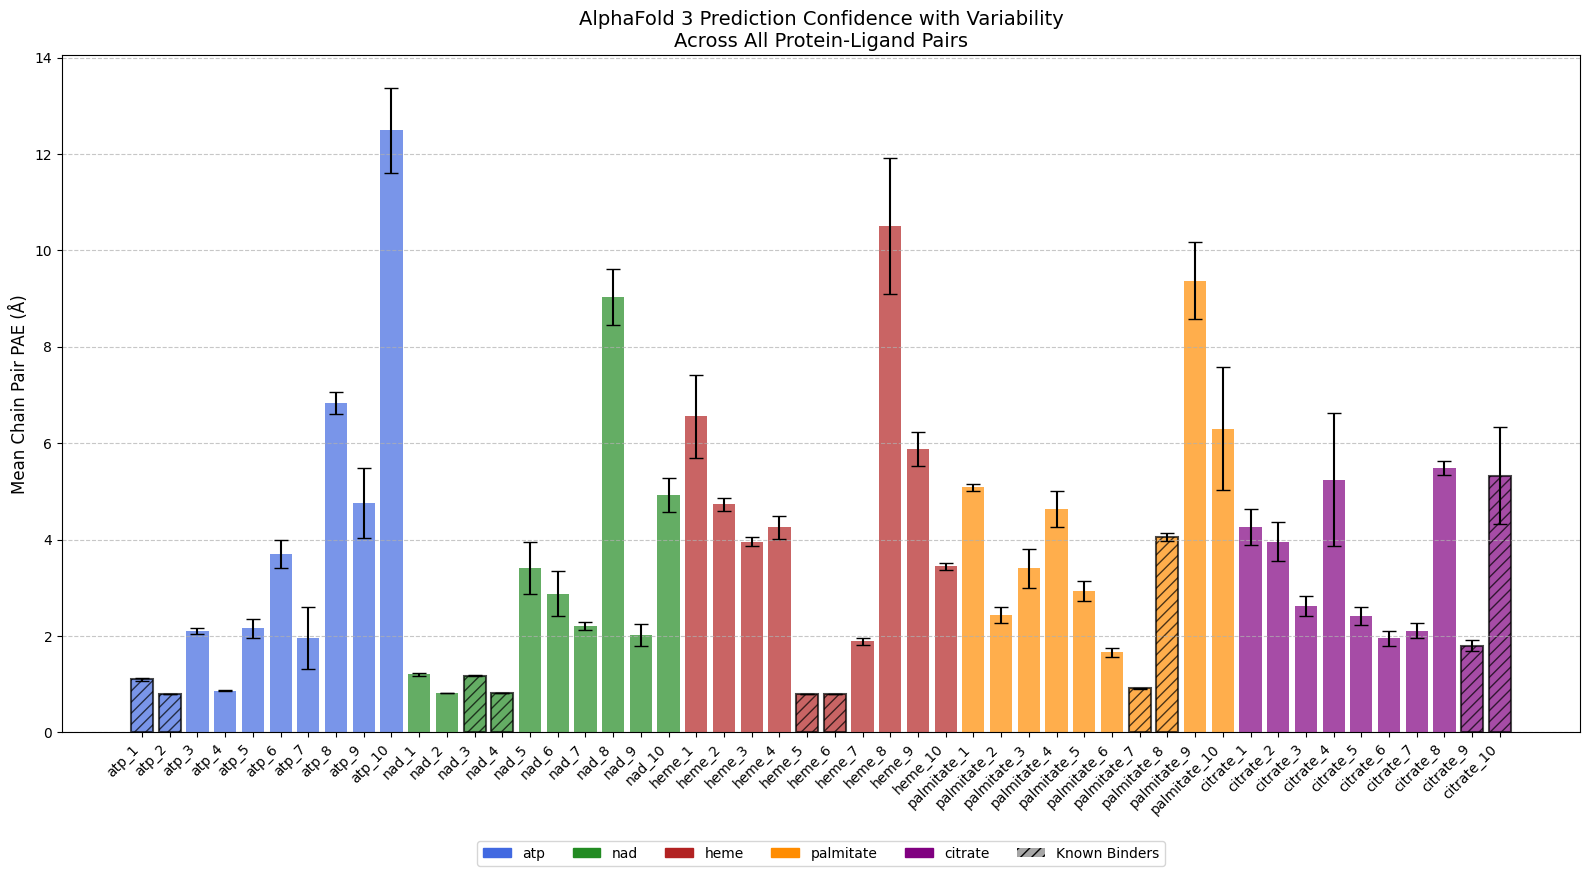

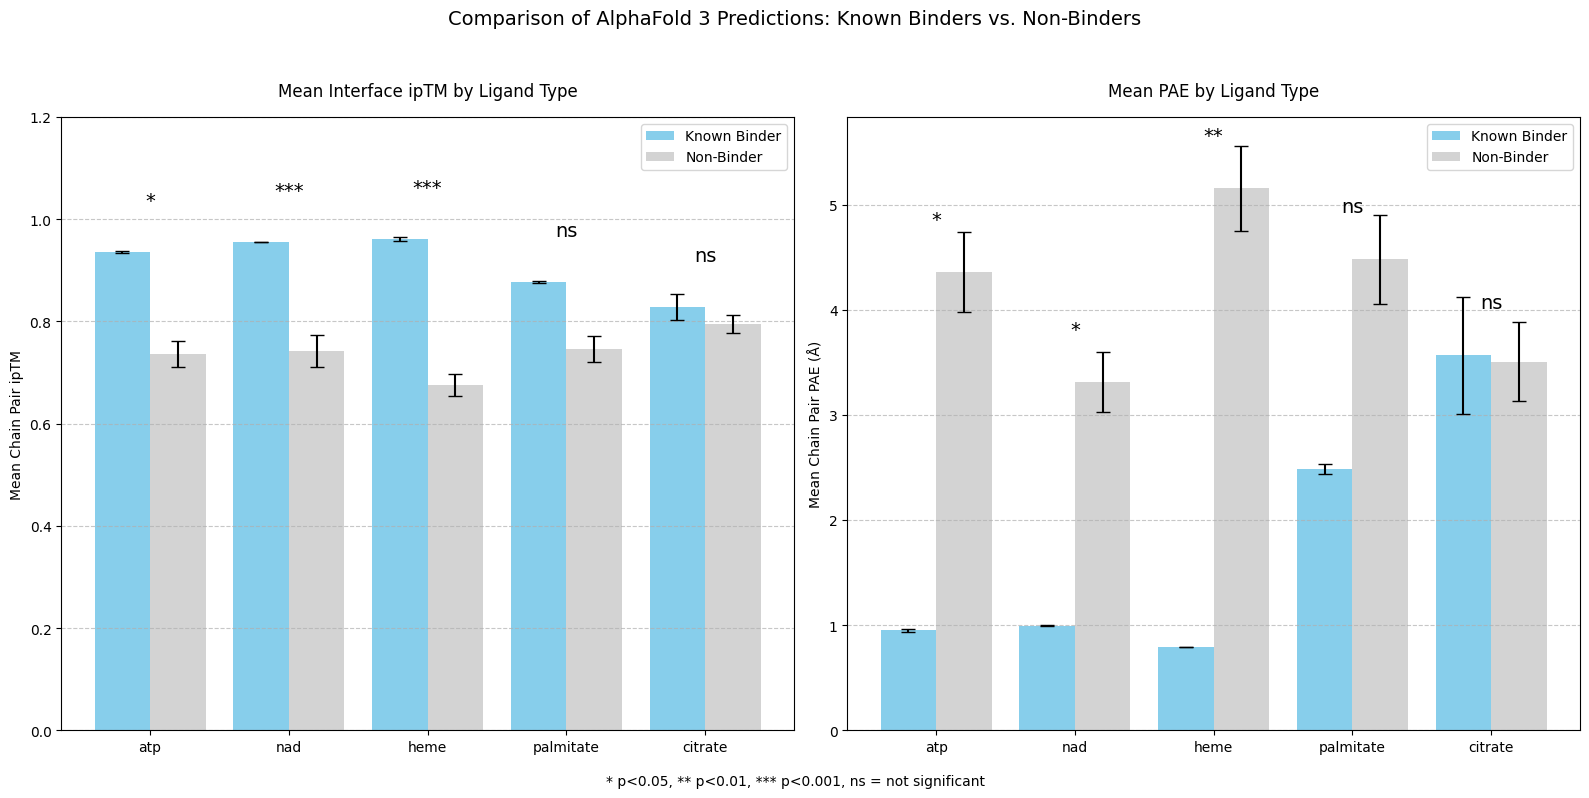

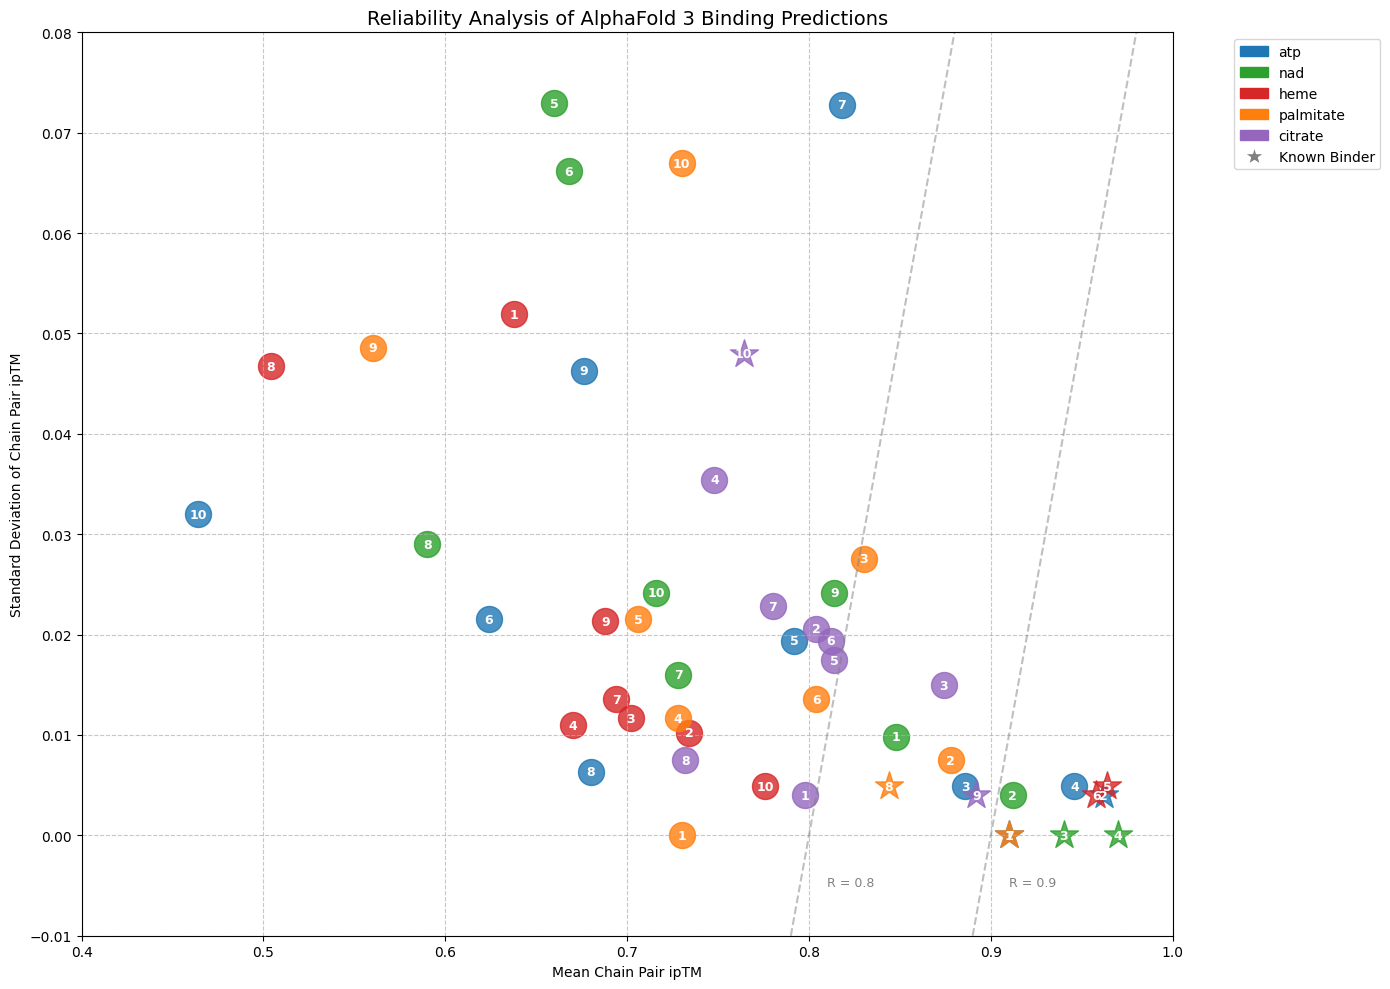


Performance Comparison: Known Binders vs. Non-Binders
                mean_chain_pair_iptm           mean_chain_pair_pae            \
                                mean       std                mean       std   
is_known_binder                                                                
False                         0.7389  0.105355             4.16185  2.644368   
True                          0.9114  0.065320             1.75720  1.605249   

                std_chain_pair_iptm std_chain_pair_pae  
                               mean               mean  
is_known_binder                                         
False                      0.024127           0.374766  
True                       0.006980           0.125321  

Ligand Performance Ranking (by mean ipTM):
             mean_chain_pair_iptm  std_chain_pair_iptm  mean_chain_pair_pae  \
ligand_type                                                                   
citrate                    0.8018             0.019411   

In [ ]:
import os
import json
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from tqdm.notebook import tqdm
import matplotlib.patches as patches
from scipy import stats

# Mount Google Drive
drive.mount('/content/drive')

# Define the base directory for data
base_dir = '/content/drive/MyDrive/alphafold3_data'

# Define known binding pairs
binding_pairs = {
    'atp': ['1', '2'],
    'nad': ['3', '4'],
    'heme': ['5', '6'],
    'palmitate': ['7', '8'],
    'citrate': ['9', '10']
}

# Define order for visualization
ligand_order = ['atp', 'nad', 'heme', 'palmitate', 'citrate']
protein_order = [str(i) for i in range(1, 11)]

def extract_metrics_from_zip(zip_path):
    """Extract confidence metrics from AlphaFold 3 prediction files"""
    metrics = {}

    with zipfile.ZipFile(zip_path, 'r') as z:
        # Find all summary confidence files
        confidence_files = [f for f in z.namelist() if 'summary_confidences_' in f]

        # Extract model numbers and sort
        model_files = []
        for file in confidence_files:
            model_num = int(file.split('_')[-1].split('.')[0])
            model_files.append((model_num, file))

        model_files.sort(key=lambda x: x[0])

        # Process each model's confidence file
        all_iptm = []
        all_ptm = []
        all_chain_pair_iptm_01 = []
        all_chain_pair_pae_01 = []
        all_ranking_scores = []

        for model_num, file in model_files:
            data = json.loads(z.read(file))

            # Store metrics
            all_iptm.append(data['iptm'])
            all_ptm.append(data['ptm'])
            all_ranking_scores.append(data['ranking_score'])
            all_chain_pair_iptm_01.append(data['chain_pair_iptm'][0][1])
            all_chain_pair_pae_01.append(data['chain_pair_pae_min'][0][1])

    # Calculate statistics
    metrics['mean_iptm'] = np.mean(all_iptm)
    metrics['std_iptm'] = np.std(all_iptm)
    metrics['mean_chain_pair_iptm'] = np.mean(all_chain_pair_iptm_01)
    metrics['std_chain_pair_iptm'] = np.std(all_chain_pair_iptm_01)
    metrics['mean_chain_pair_pae'] = np.mean(all_chain_pair_pae_01)
    metrics['std_chain_pair_pae'] = np.std(all_chain_pair_pae_01)
    metrics['top_model_iptm'] = all_iptm[0]
    metrics['top_model_chain_pair_iptm'] = all_chain_pair_iptm_01[0]
    metrics['top_model_chain_pair_pae'] = all_chain_pair_pae_01[0]

    # Store raw values
    metrics['all_iptm'] = all_iptm
    metrics['all_chain_pair_iptm'] = all_chain_pair_iptm_01
    metrics['all_chain_pair_pae'] = all_chain_pair_pae_01

    return metrics

def process_all_data(base_dir):
    """Process all ligand folders and their zip files"""
    all_results = []

    for ligand_type in ligand_order:
        if ligand_type not in os.listdir(base_dir):
            print(f"Warning: {ligand_type} folder not found")
            continue

        ligand_path = os.path.join(base_dir, ligand_type)
        zip_files = [f for f in os.listdir(ligand_path) if f.endswith('.zip')]

        print(f"Processing {ligand_type} - {len(zip_files)} files")

        for zip_file in tqdm(zip_files):
            protein_id = zip_file.split('_')[-1].split('.')[0]
            pair_id = f"{ligand_type}_{protein_id}"

            zip_path = os.path.join(ligand_path, zip_file)
            try:
                metrics = extract_metrics_from_zip(zip_path)

                # Add identifying information
                metrics['pair_id'] = pair_id
                metrics['ligand_type'] = ligand_type
                metrics['protein_id'] = protein_id
                metrics['is_known_binder'] = protein_id in binding_pairs.get(ligand_type, [])

                all_results.append(metrics)
            except Exception as e:
                print(f"Error processing {zip_file}: {e}")

    return pd.DataFrame(all_results)

def create_top_model_iptm_heatmap(df):
    """Create a heatmap of the top model's ipTM scores with known binders highlighted"""
    # Create pivot table
    pivot_df = df.pivot(index='ligand_type', columns='protein_id', values='top_model_chain_pair_iptm')

    # Reorder based on specified orders
    pivot_df = pivot_df.reindex(index=ligand_order)
    pivot_df = pivot_df.reindex(columns=protein_order)

    # Create mask for known binders
    known_binder_mask = pd.DataFrame(False, index=pivot_df.index, columns=pivot_df.columns)
    for ligand, proteins in binding_pairs.items():
        for protein in proteins:
            if ligand in known_binder_mask.index and protein in known_binder_mask.columns:
                known_binder_mask.loc[ligand, protein] = True

    # Create plot
    plt.figure(figsize=(14, 8))

    ax = sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt='.2f',
                    vmin=0, vmax=1, cbar_kws={'label': 'Chain Pair ipTM'})

    # Highlight known binders
    for i, ligand in enumerate(pivot_df.index):
        for j, protein in enumerate(pivot_df.columns):
            if known_binder_mask.loc[ligand, protein]:
                rect = patches.Rectangle((j, i), 1, 1, linewidth=2, edgecolor='black', facecolor='none')
                ax.add_patch(rect)

    # Title and legend
    plt.title('AlphaFold 3 Top Model Predictions: Chain Pair ipTM', fontsize=14, pad=20)
    black_patch = patches.Patch(edgecolor='black', facecolor='none', linewidth=2, label='Known Binders')
    plt.legend(handles=[black_patch], loc='upper right', bbox_to_anchor=(1.0, 1.0))

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/heatmap_top_model_chain_pair_iptm.png', dpi=300)
    plt.show()

def create_top_model_pae_heatmap(df):
    """Create a heatmap of the top model's PAE scores with known binders highlighted"""
    # Create pivot table
    pivot_df = df.pivot(index='ligand_type', columns='protein_id', values='top_model_chain_pair_pae')

    # Reorder
    pivot_df = pivot_df.reindex(index=ligand_order)
    pivot_df = pivot_df.reindex(columns=protein_order)

    # Create mask for known binders
    known_binder_mask = pd.DataFrame(False, index=pivot_df.index, columns=pivot_df.columns)
    for ligand, proteins in binding_pairs.items():
        for protein in proteins:
            if ligand in known_binder_mask.index and protein in known_binder_mask.columns:
                known_binder_mask.loc[ligand, protein] = True

    # Create plot
    plt.figure(figsize=(14, 8))

    ax = sns.heatmap(pivot_df, annot=True, cmap='Blues_r', fmt='.2f',
                    cbar_kws={'label': 'Chain Pair PAE (Å)'})

    # Highlight known binders
    for i, ligand in enumerate(pivot_df.index):
        for j, protein in enumerate(pivot_df.columns):
            if known_binder_mask.loc[ligand, protein]:
                rect = patches.Rectangle((j, i), 1, 1, linewidth=2, edgecolor='black', facecolor='none')
                ax.add_patch(rect)

    # Title and legend
    plt.title('AlphaFold 3 Top Model Predictions: Chain Pair PAE', fontsize=14, pad=20)
    black_patch = patches.Patch(edgecolor='black', facecolor='none', linewidth=2, label='Known Binders')
    plt.legend(handles=[black_patch], loc='upper right', bbox_to_anchor=(1.0, 1.0))

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/heatmap_top_model_chain_pair_pae.png', dpi=300)
    plt.show()

def create_individual_iptm_variance_plot(df):
    """Create a plot showing ipTM variance for each protein-ligand pair"""
    plt.figure(figsize=(16, 10))

    # Define colors for each ligand type
    ligand_colors = {
        'atp': 'royalblue',
        'nad': 'forestgreen',
        'heme': 'firebrick',
        'palmitate': 'darkorange',
        'citrate': 'purple'
    }

    # Create ordered dataframe
    ordered_df = pd.DataFrame()
    for ligand in ligand_order:
        for protein in protein_order:
            pair_id = f"{ligand}_{protein}"
            pair_data = df[df['pair_id'] == pair_id]
            if not pair_data.empty:
                ordered_df = pd.concat([ordered_df, pair_data])

    # Get metrics
    mean_metric = 'mean_chain_pair_iptm'
    std_metric = 'std_chain_pair_iptm'

    # Create x-axis values and labels
    x_ticks = np.arange(len(ordered_df))
    x_labels = ordered_df['pair_id'].values

    # Set colors
    colors = [ligand_colors[pair.split('_')[0]] for pair in ordered_df['pair_id']]

    # Create bar plot
    bars = plt.bar(x_ticks, ordered_df[mean_metric], yerr=ordered_df[std_metric], capsize=5,
                  color=colors, alpha=0.7)

    # Highlight known binders
    for i, (_, row) in enumerate(ordered_df.iterrows()):
        if row['is_known_binder']:
            bars[i].set_hatch('///')
            bars[i].set_edgecolor('black')
            bars[i].set_linewidth(1.5)

    # Labels and title
    plt.ylabel('Mean Chain Pair ipTM', fontsize=12)
    plt.title('AlphaFold 3 Prediction Confidence with Variability\nAcross All Protein-Ligand Pairs', fontsize=14)
    plt.xticks(x_ticks, x_labels, rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Legend
    legend_patches = [patches.Patch(color=color, label=ligand)
                     for ligand, color in ligand_colors.items()]
    hatch_patch = patches.Patch(facecolor='gray', hatch='///', label='Known Binders', alpha=0.7)
    legend_patches.append(hatch_patch)

    plt.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6)
    plt.ylim(0, 1.05)

    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.savefig('/content/drive/MyDrive/individual_variance_chain_pair_iptm.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_individual_pae_variance_plot(df):
    """Create a plot showing PAE variance for each protein-ligand pair"""
    plt.figure(figsize=(16, 10))

    # Define colors for each ligand type
    ligand_colors = {
        'atp': 'royalblue',
        'nad': 'forestgreen',
        'heme': 'firebrick',
        'palmitate': 'darkorange',
        'citrate': 'purple'
    }

    # Create ordered dataframe
    ordered_df = pd.DataFrame()
    for ligand in ligand_order:
        for protein in protein_order:
            pair_id = f"{ligand}_{protein}"
            pair_data = df[df['pair_id'] == pair_id]
            if not pair_data.empty:
                ordered_df = pd.concat([ordered_df, pair_data])

    # Get metrics
    mean_metric = 'mean_chain_pair_pae'
    std_metric = 'std_chain_pair_pae'

    # Create x-axis values and labels
    x_ticks = np.arange(len(ordered_df))
    x_labels = ordered_df['pair_id'].values

    # Set colors
    colors = [ligand_colors[pair.split('_')[0]] for pair in ordered_df['pair_id']]

    # Create bar plot
    bars = plt.bar(x_ticks, ordered_df[mean_metric], yerr=ordered_df[std_metric], capsize=5,
                  color=colors, alpha=0.7)

    # Highlight known binders
    for i, (_, row) in enumerate(ordered_df.iterrows()):
        if row['is_known_binder']:
            bars[i].set_hatch('///')
            bars[i].set_edgecolor('black')
            bars[i].set_linewidth(1.5)

    # Labels and title
    plt.ylabel('Mean Chain Pair PAE (Å)', fontsize=12)
    plt.title('AlphaFold 3 Prediction Confidence with Variability\nAcross All Protein-Ligand Pairs', fontsize=14)
    plt.xticks(x_ticks, x_labels, rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Legend
    legend_patches = [patches.Patch(color=color, label=ligand)
                     for ligand, color in ligand_colors.items()]
    hatch_patch = patches.Patch(facecolor='gray', hatch='///', label='Known Binders', alpha=0.7)
    legend_patches.append(hatch_patch)

    plt.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6)

    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.savefig('/content/drive/MyDrive/individual_variance_chain_pair_pae.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_ligand_variance_plot(df):
    """Create visualization showing variance analysis by ligand type with p-values"""
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Calculate statistics and p-values
    ligand_stats = []
    p_values_iptm = {}
    p_values_pae = {}

    for ligand in ligand_order:
        # Get data for this ligand
        ligand_data = df[df['ligand_type'] == ligand]

        # Known binders and non-binders
        binders = ligand_data[ligand_data['is_known_binder']]
        non_binders = ligand_data[~ligand_data['is_known_binder']]

        # Calculate p-value using t-test if sufficient data
        if len(binders) >= 2 and len(non_binders) >= 2:
            t_stat_iptm, p_val_iptm = stats.ttest_ind(
                binders['mean_chain_pair_iptm'],
                non_binders['mean_chain_pair_iptm'],
                equal_var=False  # Welch's t-test
            )
            p_values_iptm[ligand] = p_val_iptm

            t_stat_pae, p_val_pae = stats.ttest_ind(
                binders['mean_chain_pair_pae'],
                non_binders['mean_chain_pair_pae'],
                equal_var=False
            )
            p_values_pae[ligand] = p_val_pae
        else:
            # For cases where statistical test isn't possible, mark as non-significant
            p_values_iptm[ligand] = 1.0  # Non-significant
            p_values_pae[ligand] = 1.0   # Non-significant

        # Add binder stats
        if not binders.empty:
            ligand_stats.append({
                'ligand_type': ligand,
                'binding_status': 'Known Binder',
                'mean_iptm': binders['mean_chain_pair_iptm'].mean(),
                'std_iptm': binders['std_chain_pair_iptm'].mean(),
                'mean_pae': binders['mean_chain_pair_pae'].mean(),
                'std_pae': binders['std_chain_pair_pae'].mean()
            })

        # Add non-binder stats
        if not non_binders.empty:
            ligand_stats.append({
                'ligand_type': ligand,
                'binding_status': 'Non-Binder',
                'mean_iptm': non_binders['mean_chain_pair_iptm'].mean(),
                'std_iptm': non_binders['std_chain_pair_iptm'].mean(),
                'mean_pae': non_binders['mean_chain_pair_pae'].mean(),
                'std_pae': non_binders['std_chain_pair_pae'].mean()
            })

    # Convert to DataFrame
    stats_df = pd.DataFrame(ligand_stats)

    # Plot ipTM
    for i, ligand in enumerate(ligand_order):
        ligand_data = stats_df[stats_df['ligand_type'] == ligand]

        binder_data = ligand_data[ligand_data['binding_status'] == 'Known Binder']
        non_binder_data = ligand_data[ligand_data['binding_status'] == 'Non-Binder']

        # Plot binders
        if not binder_data.empty:
            ax1.bar(i-0.2, binder_data['mean_iptm'].values[0], width=0.4,
                   color='skyblue', label='Known Binder' if i == 0 else "")

            # Add error bars
            ax1.errorbar(i-0.2, binder_data['mean_iptm'].values[0],
                        yerr=binder_data['std_iptm'].values[0],
                        fmt='none', color='black', capsize=5)

        # Plot non-binders
        if not non_binder_data.empty:
            ax1.bar(i+0.2, non_binder_data['mean_iptm'].values[0], width=0.4,
                   color='lightgray', label='Non-Binder' if i == 0 else "")

            # Add error bars
            ax1.errorbar(i+0.2, non_binder_data['mean_iptm'].values[0],
                        yerr=non_binder_data['std_iptm'].values[0],
                        fmt='none', color='black', capsize=5)

        # Add p-value annotation
        if ligand in p_values_iptm:
            p_val = p_values_iptm[ligand]
            if p_val < 0.001:
                stars = '***'
            elif p_val < 0.01:
                stars = '**'
            elif p_val < 0.05:
                stars = '*'
            else:
                stars = 'ns'  # non-significant

            max_height = max(
                binder_data['mean_iptm'].values[0] if not binder_data.empty else 0,
                non_binder_data['mean_iptm'].values[0] if not non_binder_data.empty else 0
            )
            ax1.text(i, max_height + 0.1, stars,
                    ha='center', va='center', fontsize=14)

    ax1.set_title('Mean Interface ipTM by Ligand Type', fontsize=12, pad=15)
    ax1.set_ylabel('Mean Chain Pair ipTM')
    ax1.set_ylim(0, 1.2)  # Extended y-axis
    ax1.set_xticks(range(len(ligand_order)))
    ax1.set_xticklabels(ligand_order)
    ax1.legend()
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Plot PAE
    for i, ligand in enumerate(ligand_order):
        ligand_data = stats_df[stats_df['ligand_type'] == ligand]

        binder_data = ligand_data[ligand_data['binding_status'] == 'Known Binder']
        non_binder_data = ligand_data[ligand_data['binding_status'] == 'Non-Binder']

        # Plot binders
        if not binder_data.empty:
            ax2.bar(i-0.2, binder_data['mean_pae'].values[0], width=0.4,
                   color='skyblue', label='Known Binder' if i == 0 else "")

            # Add error bars
            ax2.errorbar(i-0.2, binder_data['mean_pae'].values[0],
                        yerr=binder_data['std_pae'].values[0],
                        fmt='none', color='black', capsize=5)

        # Plot non-binders
        if not non_binder_data.empty:
            ax2.bar(i+0.2, non_binder_data['mean_pae'].values[0], width=0.4,
                   color='lightgray', label='Non-Binder' if i == 0 else "")

            # Add error bars
            ax2.errorbar(i+0.2, non_binder_data['mean_pae'].values[0],
                        yerr=non_binder_data['std_pae'].values[0],
                        fmt='none', color='black', capsize=5)

        # Add p-value annotation
        if ligand in p_values_pae:
            p_val = p_values_pae[ligand]
            if p_val < 0.001:
                stars = '***'
            elif p_val < 0.01:
                stars = '**'
            elif p_val < 0.05:
                stars = '*'
            else:
                stars = 'ns'  # non-significant

            max_height = max(
                binder_data['mean_pae'].values[0] if not binder_data.empty else 0,
                non_binder_data['mean_pae'].values[0] if not non_binder_data.empty else 0
            )
            ax2.text(i, max_height + 0.5, stars,
                    ha='center', va='center', fontsize=14)

    ax2.set_title('Mean PAE by Ligand Type', fontsize=12, pad=15)
    ax2.set_ylabel('Mean Chain Pair PAE (Å)')
    ax2.set_xticks(range(len(ligand_order)))
    ax2.set_xticklabels(ligand_order)
    ax2.legend()
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    # Add significance explanation
    fig.text(0.5, 0.01, '* p<0.05, ** p<0.01, *** p<0.001, ns = not significant', ha='center', fontsize=10)

    plt.suptitle('Comparison of AlphaFold 3 Predictions: Known Binders vs. Non-Binders', fontsize=14, y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.savefig('/content/drive/MyDrive/ligand_binding_comparison.png', dpi=300)
    plt.show()

def create_reliability_scatter(df):
    """Create scatter plot showing relationship between mean and std dev with focus on specified range"""
    # Calculate reliability metric
    df['reliability'] = df['mean_chain_pair_iptm'] - df['std_chain_pair_iptm']

    # Setup figure
    plt.figure(figsize=(14, 10))

    # Setup colors
    ligand_colors = {
        'atp': '#1f77b4',      # blue
        'nad': '#2ca02c',      # green
        'heme': '#d62728',     # red
        'palmitate': '#ff7f0e', # orange
        'citrate': '#9467bd'   # purple
    }

    # Create scatter plot - with protein ID inside marker
    for ligand in ligand_order:
        ligand_data = df[df['ligand_type'] == ligand]

        # Skip if empty
        if ligand_data.empty:
            continue

        # Plot points with different markers for binders vs non-binders
        for _, row in ligand_data.iterrows():
            is_binder = row['is_known_binder']
            marker = '*' if is_binder else 'o'
            size = 450 if is_binder else 350  # Larger to fit text

            # Plot the marker
            plt.scatter(
                row['mean_chain_pair_iptm'],
                row['std_chain_pair_iptm'],
                marker=marker,
                s=size,
                color=ligand_colors[ligand],
                alpha=0.8
            )

            # Add protein ID inside marker
            plt.text(
                row['mean_chain_pair_iptm'],
                row['std_chain_pair_iptm'],
                row['protein_id'],
                ha='center',
                va='center',
                fontsize=9,
                color='white',
                fontweight='bold'
            )

    # Define the range we care about for reliability lines
    y_max = 0.08

    # Add diagonal lines representing reliability thresholds
    thresholds = [0.8, 0.9]
    for threshold in thresholds:
        # Calculate relevant x-range for this threshold
        y_min = -0.01
        x_min = threshold + y_min
        x_max = threshold + y_max

        # Only show if in our plot range
        if x_min < 1.0:
            x_vals = np.linspace(max(0.4, x_min), min(1.0, x_max), 100)
            y_vals = x_vals - threshold

            plt.plot(x_vals, y_vals, '--', color='gray', alpha=0.5)

            # Add labels at appropriate positions that don't overlap plot edges
            if x_min >= 0.4:
                # Label at the left edge
                plt.text(x_min + 0.02, y_min + 0.005, f'R = {threshold}',
                        fontsize=9, color='gray')
            else:
                # Label in the middle
                mid_x = (min(1.0, x_max) + max(0.4, x_min)) / 2
                mid_y = mid_x - threshold
                if 0 <= mid_y <= y_max:
                    plt.text(mid_x - 0.05, mid_y + 0.005, f'R = {threshold}',
                            fontsize=9, color='gray')

    # Format plot
    plt.title('Reliability Analysis of AlphaFold 3 Binding Predictions', fontsize=14)
    plt.xlabel('Mean Chain Pair ipTM')
    plt.ylabel('Standard Deviation of Chain Pair ipTM')
    plt.xlim(0.4, 1.0)         # Focus on data region
    plt.ylim(-0.01, 0.08)      # Adjusted as requested
    plt.grid(True, linestyle='--', alpha=0.7)

    # Create simplified legend
    ligand_patches = [patches.Patch(color=color, label=ligand)
                     for ligand, color in ligand_colors.items()]

    # Add marker for known binders
    binder_star = plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='gray',
                             markersize=15, label='Known Binder')

    # Combine and add legend
    handles = ligand_patches + [binder_star]
    plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/reliability_scatter.png', dpi=300, bbox_inches='tight')
    plt.show()

def run_analysis():
    """Main function to run the complete analysis pipeline"""
    # Process data
    results_df = process_all_data(base_dir)

    # Save results
    results_df.to_csv('/content/drive/MyDrive/alphafold3_results.csv', index=False)

    # Create summary view
    view_columns = [col for col in results_df.columns if not col.startswith('all_')]
    view_df = results_df[view_columns]
    view_df.to_csv('/content/drive/MyDrive/alphafold3_results_summary.csv', index=False)

    print(f"Processed {len(results_df)} protein-ligand pairs")

    # Generate plots
    create_top_model_iptm_heatmap(results_df)
    create_top_model_pae_heatmap(results_df)
    create_individual_iptm_variance_plot(results_df)
    create_individual_pae_variance_plot(results_df)
    create_ligand_variance_plot(results_df)
    create_reliability_scatter(results_df)

    # Calculate statistics
    calculate_statistics(results_df)

    return results_df

def calculate_statistics(df):
    """Calculate and print key statistics for the paper"""
    # Performance comparison: binders vs non-binders
    binder_stats = df.groupby('is_known_binder').agg({
        'mean_chain_pair_iptm': ['mean', 'std'],
        'mean_chain_pair_pae': ['mean', 'std'],
        'std_chain_pair_iptm': 'mean',
        'std_chain_pair_pae': 'mean'
    })

    print("\nPerformance Comparison: Known Binders vs. Non-Binders")
    print(binder_stats)

    # Ligand performance ranking
    ligand_stats = df.groupby('ligand_type').agg({
        'mean_chain_pair_iptm': 'mean',
        'std_chain_pair_iptm': 'mean',
        'mean_chain_pair_pae': 'mean',
        'std_chain_pair_pae': 'mean'
    }).sort_values('mean_chain_pair_iptm', ascending=False)

    print("\nLigand Performance Ranking (by mean ipTM):")
    print(ligand_stats)

    # Most reliable predictions
    df['reliability'] = df['mean_chain_pair_iptm'] - df['std_chain_pair_iptm']
    top_5 = df[['pair_id', 'ligand_type', 'protein_id', 'is_known_binder',
               'mean_chain_pair_iptm', 'std_chain_pair_iptm', 'reliability']] \
            .sort_values('reliability', ascending=False).head(5)

    print("\nTop 5 Most Reliable Protein-Ligand Pairs:")
    print(top_5)

    # Discrimination power
    from sklearn.metrics import roc_auc_score, precision_score, recall_score

    y_true = df['is_known_binder'].astype(int)
    y_score = df['mean_chain_pair_iptm']

    auc = roc_auc_score(y_true, y_score)
    print(f"\nROC AUC Score (ipTM as predictor of binding): {auc:.3f}")

    # Classification metrics at threshold
    threshold = 0.8
    y_pred = (y_score >= threshold).astype(int)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    print(f"At threshold {threshold}:")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")

# Run the full analysis
if __name__ == "__main__":
    results = run_analysis()